# Leukemia Classification and Grading (Complete Pipeline)

This notebook orchestrates the entire pipeline for the Leukemia Classification and Grading project:
1.  **Setup**: Imports libraries and configures paths.
2.  **Data Preparation**: Preprocesses and splits the data into training, validation, and test sets.
3.  **Model Training**: Trains both a baseline and a multi-task model.
4.  **Prediction**: Uses the trained multi-task model to classify a new, single image.

## 1. Setup: Imports and Configuration

In [5]:
import os
import logging
import random
import shutil
import glob
from pathlib import Path

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

### Configuration

In [6]:
PROJECT_ROOT = Path('/Users/adarshainamdar/Documents/Major_Project')
DATA_DIR_RAW = PROJECT_ROOT / 'data/raw'

OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
PROCESSED_DATA_DIR = PROJECT_ROOT / 'data/processed_data'
PROCESSED_DIR = PROCESSED_DATA_DIR / 'processed'
TRAIN_DIR = PROCESSED_DATA_DIR / 'train'
VAL_DIR = PROCESSED_DATA_DIR / 'val'
TEST_DIR = PROCESSED_DATA_DIR / 'test'
MODEL_DIR = OUTPUTS_DIR / 'models'
LOG_DIR = OUTPUTS_DIR / 'logs'

IMAGE_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
CLASSES = ['ALL', 'AML', 'CLL', 'CML']
GRADES = ['Chronic', 'Accelerated', 'Blast']

### Training Parameters

In [7]:
NUM_EPOCHS = 500
SKIP_DATA_PREP = False

## 2. Helper Functions and Classes

In [8]:
def setup_logging():
    """Configures the logging for the entire script."""
    LOG_DIR.mkdir(parents=True, exist_ok=True)
    LOG_FILE = LOG_DIR / 'training_notebook.log'
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
        
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(LOG_FILE, mode='w'),
            logging.StreamHandler()
        ]
    )
    logging.info(f"Logging setup complete. Log file: {LOG_FILE.resolve()}")

In [9]:
def prepare_data():
    """Checks for local data, then preprocesses and splits it."""
    if not DATA_DIR_RAW.exists():
        logging.error(f"Local data directory not found at '{DATA_DIR_RAW.resolve()}'.")
        return False
    else:
        logging.info(f"Found local data at '{DATA_DIR_RAW.resolve()}'.")

    logging.info("Starting image preprocessing (resizing to %dx%d)...", IMAGE_SIZE, IMAGE_SIZE)
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff']

    for cls in CLASSES:
        in_dir = DATA_DIR_RAW / cls
        out_dir = PROCESSED_DIR / cls
        out_dir.mkdir(parents=True, exist_ok=True)
        
        image_paths = []
        for ext in image_extensions:
            image_paths.extend(glob.glob(str(in_dir / '**' / ext), recursive=True))
            image_paths.extend(glob.glob(str(in_dir / '**' / ext.upper()), recursive=True))

        if not image_paths:
            logging.warning(f"No images found for class '{cls}' in directory '{in_dir}'. Skipping this class.")
            continue

        for fp in tqdm(image_paths, desc=f"Processing {cls}"):
            img = cv2.imread(fp)
            if img is not None:
                img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
                unique_name = f"{Path(fp).parent.name}_{Path(fp).name}"
                cv2.imwrite(str(out_dir / unique_name), img_resized)

    logging.info("Image preprocessing complete.")

    logging.info("Splitting data into train, validation, and test sets.")
    random.seed(42)
    for cls in CLASSES:
        files = list((PROCESSED_DIR / cls).glob('*.*'))
        if not files:
            continue
        random.shuffle(files)
        n = len(files)
        n_train, n_val = int(0.7 * n), int(0.15 * n)
        train_files, val_files, test_files = files[:n_train], files[n_train:n_train + n_val], files[n_train + n_val:]

        for d, fileset in [("train", train_files), ("val", val_files), ("test", test_files)]:
            dest_dir = PROCESSED_DATA_DIR / d / cls
            dest_dir.mkdir(parents=True, exist_ok=True)
            for f in fileset:
                shutil.copy2(f, dest_dir / f.name)
    logging.info("Data splitting complete.")

    total_files_in_train = sum([len(files) for r, d, files in os.walk(str(TRAIN_DIR))])
    if total_files_in_train == 0:
        logging.error("Data preparation step ran, but the training directory is empty.")
        return False
    
    return True

In [10]:
class MultiTaskModel(nn.Module):
    """A ResNet18 model with two separate heads for classification and grading."""
    def __init__(self, n_types, n_grades):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        d_model = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.head_type = nn.Linear(d_model, n_types)
        self.head_grade = nn.Linear(d_model, n_grades)

    def forward(self, x):
        features = self.backbone(x)
        return self.head_type(features), self.head_grade(features)

class MultiTaskDataset(datasets.ImageFolder):
    """Custom dataset to return type and (simulated) grade labels."""
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)
        self.grade_map = {cls: i % len(GRADES) for i, cls in enumerate(self.classes)}

    def __getitem__(self, index):
        path, type_label = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        
        class_name = self.classes[type_label]
        grade_label = self.grade_map[class_name]
        
        return sample, type_label, grade_label

In [11]:
def train_baseline_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs):
    logging.info("--- Starting Baseline Model Training ---")
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.item() / len(val_loader.dataset)
        logging.info(f"Epoch {epoch+1}/{num_epochs} | Validation Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_DIR / 'baseline_cls.pt')
            logging.info(f"New best baseline model saved with acc: {best_val_acc:.4f}")

In [12]:
def train_multitask_model(model, criteria, optimizer, train_loader, val_loader, device, num_epochs):
    logging.info("--- Starting Multi-Task Model Training ---")
    model.to(device)
    best_val_acc = 0.0
    type_criterion, grade_criterion = criteria

    for epoch in range(num_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for inputs, type_labels, grade_labels in loop:
            inputs, type_labels, grade_labels = inputs.to(device), type_labels.to(device), grade_labels.to(device)
            optimizer.zero_grad()
            type_logits, grade_logits = model(inputs)
            loss = type_criterion(type_logits, type_labels) + 0.5 * grade_criterion(grade_logits, grade_labels)
            loss.backward()
            optimizer.step()

        model.eval()
        type_corrects = 0
        with torch.no_grad():
            for inputs, type_labels, _ in val_loader:
                inputs, type_labels = inputs.to(device), type_labels.to(device)
                type_logits, _ = model(inputs)
                _, type_preds = torch.max(type_logits, 1)
                type_corrects += torch.sum(type_preds == type_labels.data)
        
        val_type_acc = type_corrects.item() / len(val_loader.dataset)
        logging.info(f"Epoch {epoch+1}/{num_epochs} | Validation Type Acc: {val_type_acc:.4f}")

        if val_type_acc > best_val_acc:
            best_val_acc = val_type_acc
            torch.save(model.state_dict(), MODEL_DIR / 'multitask_model.pt')
            logging.info(f"New best multi-task model saved with acc: {best_val_acc:.4f}")

In [13]:
def evaluate_model(model, loader, device, class_names):
    logging.info("--- Evaluating Model on Test Set ---")
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    report = classification_report(y_true, y_pred, target_names=class_names)
    logging.info("Classification Report:\n%s", report)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## 3. Main Pipeline Execution

This block runs the entire data preparation and training pipeline.

2025-09-13 08:02:10,793 - INFO - Logging setup complete. Log file: /Users/adarshainamdar/Documents/Major_Project/outputs/logs/training_notebook.log
2025-09-13 08:02:10,794 - INFO - Found local data at '/Users/adarshainamdar/Documents/Major_Project/data/raw'.
2025-09-13 08:02:10,795 - INFO - Starting image preprocessing (resizing to 224x224)...


Processing ALL:   0%|          | 0/320 [00:00<?, ?it/s]

Processing AML:   0%|          | 0/320 [00:00<?, ?it/s]

Processing CLL:   0%|          | 0/320 [00:00<?, ?it/s]

Processing CML:   0%|          | 0/320 [00:00<?, ?it/s]

2025-09-13 08:02:12,216 - INFO - Image preprocessing complete.
2025-09-13 08:02:12,217 - INFO - Splitting data into train, validation, and test sets.
2025-09-13 08:02:12,641 - INFO - Data splitting complete.
2025-09-13 08:02:12,656 - INFO - Using device: mps
2025-09-13 08:02:12,657 - INFO - 
=== BASELINE MODEL PIPELINE ===
2025-09-13 08:02:12,832 - INFO - --- Starting Baseline Model Training ---


Epoch 1/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:17,862 - INFO - Epoch 1/500 | Validation Acc: 0.5990
2025-09-13 08:02:17,936 - INFO - New best baseline model saved with acc: 0.5990


Epoch 2/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:22,457 - INFO - Epoch 2/500 | Validation Acc: 0.5885


Epoch 3/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:26,883 - INFO - Epoch 3/500 | Validation Acc: 0.6615
2025-09-13 08:02:26,962 - INFO - New best baseline model saved with acc: 0.6615


Epoch 4/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:31,464 - INFO - Epoch 4/500 | Validation Acc: 0.5990


Epoch 5/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:35,876 - INFO - Epoch 5/500 | Validation Acc: 0.4427


Epoch 6/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:40,262 - INFO - Epoch 6/500 | Validation Acc: 0.6927
2025-09-13 08:02:40,336 - INFO - New best baseline model saved with acc: 0.6927


Epoch 7/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:44,748 - INFO - Epoch 7/500 | Validation Acc: 0.6406


Epoch 8/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:49,272 - INFO - Epoch 8/500 | Validation Acc: 0.7188
2025-09-13 08:02:49,343 - INFO - New best baseline model saved with acc: 0.7188


Epoch 9/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:53,931 - INFO - Epoch 9/500 | Validation Acc: 0.6146


Epoch 10/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:02:58,364 - INFO - Epoch 10/500 | Validation Acc: 0.6667


Epoch 11/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:02,777 - INFO - Epoch 11/500 | Validation Acc: 0.6667


Epoch 12/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:07,242 - INFO - Epoch 12/500 | Validation Acc: 0.7135


Epoch 13/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:11,673 - INFO - Epoch 13/500 | Validation Acc: 0.8125
2025-09-13 08:03:11,745 - INFO - New best baseline model saved with acc: 0.8125


Epoch 14/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:16,199 - INFO - Epoch 14/500 | Validation Acc: 0.6823


Epoch 15/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:20,636 - INFO - Epoch 15/500 | Validation Acc: 0.7969


Epoch 16/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:25,026 - INFO - Epoch 16/500 | Validation Acc: 0.7500


Epoch 17/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:29,415 - INFO - Epoch 17/500 | Validation Acc: 0.6615


Epoch 18/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:33,849 - INFO - Epoch 18/500 | Validation Acc: 0.5729


Epoch 19/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:38,241 - INFO - Epoch 19/500 | Validation Acc: 0.7812


Epoch 20/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:42,632 - INFO - Epoch 20/500 | Validation Acc: 0.8229
2025-09-13 08:03:42,701 - INFO - New best baseline model saved with acc: 0.8229


Epoch 21/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:47,112 - INFO - Epoch 21/500 | Validation Acc: 0.7812


Epoch 22/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:51,632 - INFO - Epoch 22/500 | Validation Acc: 0.8698
2025-09-13 08:03:51,698 - INFO - New best baseline model saved with acc: 0.8698


Epoch 23/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:03:56,129 - INFO - Epoch 23/500 | Validation Acc: 0.7708


Epoch 24/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:00,587 - INFO - Epoch 24/500 | Validation Acc: 0.6094


Epoch 25/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:05,047 - INFO - Epoch 25/500 | Validation Acc: 0.7292


Epoch 26/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:09,491 - INFO - Epoch 26/500 | Validation Acc: 0.8385


Epoch 27/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:14,026 - INFO - Epoch 27/500 | Validation Acc: 0.8594


Epoch 28/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:18,475 - INFO - Epoch 28/500 | Validation Acc: 0.8229


Epoch 29/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:22,895 - INFO - Epoch 29/500 | Validation Acc: 0.8281


Epoch 30/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:27,323 - INFO - Epoch 30/500 | Validation Acc: 0.8125


Epoch 31/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:31,787 - INFO - Epoch 31/500 | Validation Acc: 0.7969


Epoch 32/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:36,266 - INFO - Epoch 32/500 | Validation Acc: 0.6927


Epoch 33/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:40,761 - INFO - Epoch 33/500 | Validation Acc: 0.8542


Epoch 34/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:45,406 - INFO - Epoch 34/500 | Validation Acc: 0.8229


Epoch 35/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:50,067 - INFO - Epoch 35/500 | Validation Acc: 0.7292


Epoch 36/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:54,534 - INFO - Epoch 36/500 | Validation Acc: 0.8177


Epoch 37/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:04:58,958 - INFO - Epoch 37/500 | Validation Acc: 0.7969


Epoch 38/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:03,392 - INFO - Epoch 38/500 | Validation Acc: 0.8229


Epoch 39/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:07,899 - INFO - Epoch 39/500 | Validation Acc: 0.7552


Epoch 40/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:12,319 - INFO - Epoch 40/500 | Validation Acc: 0.8438


Epoch 41/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:16,752 - INFO - Epoch 41/500 | Validation Acc: 0.8646


Epoch 42/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:21,241 - INFO - Epoch 42/500 | Validation Acc: 0.8385


Epoch 43/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:25,683 - INFO - Epoch 43/500 | Validation Acc: 0.8021


Epoch 44/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:30,184 - INFO - Epoch 44/500 | Validation Acc: 0.8646


Epoch 45/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:34,690 - INFO - Epoch 45/500 | Validation Acc: 0.8177


Epoch 46/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:39,096 - INFO - Epoch 46/500 | Validation Acc: 0.8125


Epoch 47/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:43,559 - INFO - Epoch 47/500 | Validation Acc: 0.8542


Epoch 48/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:47,971 - INFO - Epoch 48/500 | Validation Acc: 0.7656


Epoch 49/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:52,375 - INFO - Epoch 49/500 | Validation Acc: 0.8646


Epoch 50/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:05:56,782 - INFO - Epoch 50/500 | Validation Acc: 0.8906
2025-09-13 08:05:56,860 - INFO - New best baseline model saved with acc: 0.8906


Epoch 51/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:01,305 - INFO - Epoch 51/500 | Validation Acc: 0.8385


Epoch 52/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:05,811 - INFO - Epoch 52/500 | Validation Acc: 0.7969


Epoch 53/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:10,257 - INFO - Epoch 53/500 | Validation Acc: 0.9010
2025-09-13 08:06:10,335 - INFO - New best baseline model saved with acc: 0.9010


Epoch 54/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:14,752 - INFO - Epoch 54/500 | Validation Acc: 0.8854


Epoch 55/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:19,158 - INFO - Epoch 55/500 | Validation Acc: 0.9062
2025-09-13 08:06:19,228 - INFO - New best baseline model saved with acc: 0.9062


Epoch 56/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:23,628 - INFO - Epoch 56/500 | Validation Acc: 0.9167
2025-09-13 08:06:23,698 - INFO - New best baseline model saved with acc: 0.9167


Epoch 57/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:28,087 - INFO - Epoch 57/500 | Validation Acc: 0.8854


Epoch 58/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:32,503 - INFO - Epoch 58/500 | Validation Acc: 0.8854


Epoch 59/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:36,951 - INFO - Epoch 59/500 | Validation Acc: 0.8698


Epoch 60/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:41,392 - INFO - Epoch 60/500 | Validation Acc: 0.8125


Epoch 61/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:45,794 - INFO - Epoch 61/500 | Validation Acc: 0.8854


Epoch 62/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:50,241 - INFO - Epoch 62/500 | Validation Acc: 0.8802


Epoch 63/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:54,688 - INFO - Epoch 63/500 | Validation Acc: 0.8906


Epoch 64/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:06:59,134 - INFO - Epoch 64/500 | Validation Acc: 0.8490


Epoch 65/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:03,561 - INFO - Epoch 65/500 | Validation Acc: 0.8542


Epoch 66/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:08,005 - INFO - Epoch 66/500 | Validation Acc: 0.8750


Epoch 67/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:12,509 - INFO - Epoch 67/500 | Validation Acc: 0.8490


Epoch 68/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:17,041 - INFO - Epoch 68/500 | Validation Acc: 0.9062


Epoch 69/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:21,491 - INFO - Epoch 69/500 | Validation Acc: 0.8333


Epoch 70/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:25,930 - INFO - Epoch 70/500 | Validation Acc: 0.8854


Epoch 71/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:30,357 - INFO - Epoch 71/500 | Validation Acc: 0.9219
2025-09-13 08:07:30,452 - INFO - New best baseline model saved with acc: 0.9219


Epoch 72/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:34,902 - INFO - Epoch 72/500 | Validation Acc: 0.9062


Epoch 73/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:39,347 - INFO - Epoch 73/500 | Validation Acc: 0.8854


Epoch 74/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:43,812 - INFO - Epoch 74/500 | Validation Acc: 0.9062


Epoch 75/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:48,246 - INFO - Epoch 75/500 | Validation Acc: 0.9010


Epoch 76/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:52,780 - INFO - Epoch 76/500 | Validation Acc: 0.8646


Epoch 77/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:07:57,220 - INFO - Epoch 77/500 | Validation Acc: 0.7969


Epoch 78/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:01,671 - INFO - Epoch 78/500 | Validation Acc: 0.9167


Epoch 79/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:06,133 - INFO - Epoch 79/500 | Validation Acc: 0.8698


Epoch 80/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:10,575 - INFO - Epoch 80/500 | Validation Acc: 0.8385


Epoch 81/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:15,012 - INFO - Epoch 81/500 | Validation Acc: 0.8750


Epoch 82/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:19,445 - INFO - Epoch 82/500 | Validation Acc: 0.9010


Epoch 83/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:23,848 - INFO - Epoch 83/500 | Validation Acc: 0.8854


Epoch 84/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:28,264 - INFO - Epoch 84/500 | Validation Acc: 0.9167


Epoch 85/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:32,703 - INFO - Epoch 85/500 | Validation Acc: 0.9062


Epoch 86/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:37,175 - INFO - Epoch 86/500 | Validation Acc: 0.8854


Epoch 87/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:41,617 - INFO - Epoch 87/500 | Validation Acc: 0.8177


Epoch 88/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:46,073 - INFO - Epoch 88/500 | Validation Acc: 0.8125


Epoch 89/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:50,590 - INFO - Epoch 89/500 | Validation Acc: 0.8698


Epoch 90/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:55,153 - INFO - Epoch 90/500 | Validation Acc: 0.8958


Epoch 91/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:08:59,641 - INFO - Epoch 91/500 | Validation Acc: 0.7865


Epoch 92/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:04,092 - INFO - Epoch 92/500 | Validation Acc: 0.8385


Epoch 93/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:08,577 - INFO - Epoch 93/500 | Validation Acc: 0.8854


Epoch 94/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:13,060 - INFO - Epoch 94/500 | Validation Acc: 0.8750


Epoch 95/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:17,476 - INFO - Epoch 95/500 | Validation Acc: 0.9062


Epoch 96/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:21,885 - INFO - Epoch 96/500 | Validation Acc: 0.9010


Epoch 97/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:26,289 - INFO - Epoch 97/500 | Validation Acc: 0.8906


Epoch 98/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:30,750 - INFO - Epoch 98/500 | Validation Acc: 0.8698


Epoch 99/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:35,226 - INFO - Epoch 99/500 | Validation Acc: 0.8594


Epoch 100/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:39,600 - INFO - Epoch 100/500 | Validation Acc: 0.8490


Epoch 101/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:44,148 - INFO - Epoch 101/500 | Validation Acc: 0.8594


Epoch 102/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:48,652 - INFO - Epoch 102/500 | Validation Acc: 0.9010


Epoch 103/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:53,094 - INFO - Epoch 103/500 | Validation Acc: 0.9115


Epoch 104/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:09:57,550 - INFO - Epoch 104/500 | Validation Acc: 0.8906


Epoch 105/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:02,057 - INFO - Epoch 105/500 | Validation Acc: 0.8438


Epoch 106/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:06,556 - INFO - Epoch 106/500 | Validation Acc: 0.8646


Epoch 107/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:10,987 - INFO - Epoch 107/500 | Validation Acc: 0.8542


Epoch 108/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:15,431 - INFO - Epoch 108/500 | Validation Acc: 0.8646


Epoch 109/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:19,883 - INFO - Epoch 109/500 | Validation Acc: 0.8073


Epoch 110/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:24,326 - INFO - Epoch 110/500 | Validation Acc: 0.9115


Epoch 111/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:28,745 - INFO - Epoch 111/500 | Validation Acc: 0.9115


Epoch 112/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:33,204 - INFO - Epoch 112/500 | Validation Acc: 0.8438


Epoch 113/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:37,632 - INFO - Epoch 113/500 | Validation Acc: 0.8750


Epoch 114/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:42,065 - INFO - Epoch 114/500 | Validation Acc: 0.8698


Epoch 115/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:46,492 - INFO - Epoch 115/500 | Validation Acc: 0.8906


Epoch 116/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:50,925 - INFO - Epoch 116/500 | Validation Acc: 0.9115


Epoch 117/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:55,343 - INFO - Epoch 117/500 | Validation Acc: 0.8229


Epoch 118/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:10:59,776 - INFO - Epoch 118/500 | Validation Acc: 0.8177


Epoch 119/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:04,241 - INFO - Epoch 119/500 | Validation Acc: 0.8750


Epoch 120/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:08,671 - INFO - Epoch 120/500 | Validation Acc: 0.8333


Epoch 121/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:13,105 - INFO - Epoch 121/500 | Validation Acc: 0.8906


Epoch 122/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:17,536 - INFO - Epoch 122/500 | Validation Acc: 0.9010


Epoch 123/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:21,958 - INFO - Epoch 123/500 | Validation Acc: 0.7604


Epoch 124/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:26,384 - INFO - Epoch 124/500 | Validation Acc: 0.8333


Epoch 125/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:30,779 - INFO - Epoch 125/500 | Validation Acc: 0.9167


Epoch 126/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:35,199 - INFO - Epoch 126/500 | Validation Acc: 0.8906


Epoch 127/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:39,646 - INFO - Epoch 127/500 | Validation Acc: 0.9010


Epoch 128/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:44,099 - INFO - Epoch 128/500 | Validation Acc: 0.8958


Epoch 129/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:48,527 - INFO - Epoch 129/500 | Validation Acc: 0.8490


Epoch 130/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:52,969 - INFO - Epoch 130/500 | Validation Acc: 0.9219


Epoch 131/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:11:57,415 - INFO - Epoch 131/500 | Validation Acc: 0.8854


Epoch 132/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:01,870 - INFO - Epoch 132/500 | Validation Acc: 0.9219


Epoch 133/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:06,320 - INFO - Epoch 133/500 | Validation Acc: 0.8750


Epoch 134/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:10,767 - INFO - Epoch 134/500 | Validation Acc: 0.8906


Epoch 135/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:15,317 - INFO - Epoch 135/500 | Validation Acc: 0.8698


Epoch 136/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:19,867 - INFO - Epoch 136/500 | Validation Acc: 0.8542


Epoch 137/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:24,334 - INFO - Epoch 137/500 | Validation Acc: 0.8438


Epoch 138/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:28,814 - INFO - Epoch 138/500 | Validation Acc: 0.8646


Epoch 139/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:33,341 - INFO - Epoch 139/500 | Validation Acc: 0.8333


Epoch 140/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:37,863 - INFO - Epoch 140/500 | Validation Acc: 0.9010


Epoch 141/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:42,391 - INFO - Epoch 141/500 | Validation Acc: 0.9010


Epoch 142/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:46,972 - INFO - Epoch 142/500 | Validation Acc: 0.9062


Epoch 143/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:51,688 - INFO - Epoch 143/500 | Validation Acc: 0.9115


Epoch 144/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:12:56,310 - INFO - Epoch 144/500 | Validation Acc: 0.8542


Epoch 145/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:00,974 - INFO - Epoch 145/500 | Validation Acc: 0.8177


Epoch 146/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:05,577 - INFO - Epoch 146/500 | Validation Acc: 0.9115


Epoch 147/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:10,309 - INFO - Epoch 147/500 | Validation Acc: 0.8802


Epoch 148/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:15,000 - INFO - Epoch 148/500 | Validation Acc: 0.8646


Epoch 149/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:19,640 - INFO - Epoch 149/500 | Validation Acc: 0.8594


Epoch 150/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:24,294 - INFO - Epoch 150/500 | Validation Acc: 0.8229


Epoch 151/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:28,964 - INFO - Epoch 151/500 | Validation Acc: 0.8177


Epoch 152/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:33,673 - INFO - Epoch 152/500 | Validation Acc: 0.8385


Epoch 153/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:38,316 - INFO - Epoch 153/500 | Validation Acc: 0.8438


Epoch 154/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:42,980 - INFO - Epoch 154/500 | Validation Acc: 0.8854


Epoch 155/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:47,591 - INFO - Epoch 155/500 | Validation Acc: 0.8854


Epoch 156/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:52,264 - INFO - Epoch 156/500 | Validation Acc: 0.9271
2025-09-13 08:13:52,339 - INFO - New best baseline model saved with acc: 0.9271


Epoch 157/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:13:56,965 - INFO - Epoch 157/500 | Validation Acc: 0.9219


Epoch 158/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:01,641 - INFO - Epoch 158/500 | Validation Acc: 0.9271


Epoch 159/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:06,316 - INFO - Epoch 159/500 | Validation Acc: 0.9167


Epoch 160/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:10,991 - INFO - Epoch 160/500 | Validation Acc: 0.9323
2025-09-13 08:14:11,057 - INFO - New best baseline model saved with acc: 0.9323


Epoch 161/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:15,787 - INFO - Epoch 161/500 | Validation Acc: 0.9323


Epoch 162/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:20,530 - INFO - Epoch 162/500 | Validation Acc: 0.9271


Epoch 163/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:25,211 - INFO - Epoch 163/500 | Validation Acc: 0.9271


Epoch 164/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:29,897 - INFO - Epoch 164/500 | Validation Acc: 0.9115


Epoch 165/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:34,971 - INFO - Epoch 165/500 | Validation Acc: 0.9271


Epoch 166/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:39,835 - INFO - Epoch 166/500 | Validation Acc: 0.9062


Epoch 167/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:44,721 - INFO - Epoch 167/500 | Validation Acc: 0.8854


Epoch 168/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:49,507 - INFO - Epoch 168/500 | Validation Acc: 0.9375
2025-09-13 08:14:49,585 - INFO - New best baseline model saved with acc: 0.9375


Epoch 169/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:54,349 - INFO - Epoch 169/500 | Validation Acc: 0.9271


Epoch 170/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:14:59,116 - INFO - Epoch 170/500 | Validation Acc: 0.9219


Epoch 171/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:03,880 - INFO - Epoch 171/500 | Validation Acc: 0.8385


Epoch 172/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:08,606 - INFO - Epoch 172/500 | Validation Acc: 0.7865


Epoch 173/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:13,309 - INFO - Epoch 173/500 | Validation Acc: 0.9062


Epoch 174/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:18,021 - INFO - Epoch 174/500 | Validation Acc: 0.8750


Epoch 175/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:22,785 - INFO - Epoch 175/500 | Validation Acc: 0.9010


Epoch 176/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:27,512 - INFO - Epoch 176/500 | Validation Acc: 0.8542


Epoch 177/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:32,195 - INFO - Epoch 177/500 | Validation Acc: 0.8750


Epoch 178/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:36,954 - INFO - Epoch 178/500 | Validation Acc: 0.8854


Epoch 179/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:41,717 - INFO - Epoch 179/500 | Validation Acc: 0.8854


Epoch 180/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:46,551 - INFO - Epoch 180/500 | Validation Acc: 0.8958


Epoch 181/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:51,342 - INFO - Epoch 181/500 | Validation Acc: 0.9115


Epoch 182/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:15:55,985 - INFO - Epoch 182/500 | Validation Acc: 0.8958


Epoch 183/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:00,594 - INFO - Epoch 183/500 | Validation Acc: 0.8958


Epoch 184/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:05,161 - INFO - Epoch 184/500 | Validation Acc: 0.7969


Epoch 185/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:09,718 - INFO - Epoch 185/500 | Validation Acc: 0.8594


Epoch 186/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:14,305 - INFO - Epoch 186/500 | Validation Acc: 0.8698


Epoch 187/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:18,866 - INFO - Epoch 187/500 | Validation Acc: 0.8594


Epoch 188/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:23,427 - INFO - Epoch 188/500 | Validation Acc: 0.9115


Epoch 189/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:27,965 - INFO - Epoch 189/500 | Validation Acc: 0.9167


Epoch 190/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:32,509 - INFO - Epoch 190/500 | Validation Acc: 0.9062


Epoch 191/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:37,072 - INFO - Epoch 191/500 | Validation Acc: 0.8906


Epoch 192/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:41,638 - INFO - Epoch 192/500 | Validation Acc: 0.8750


Epoch 193/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:46,230 - INFO - Epoch 193/500 | Validation Acc: 0.8958


Epoch 194/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:50,786 - INFO - Epoch 194/500 | Validation Acc: 0.8333


Epoch 195/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:55,363 - INFO - Epoch 195/500 | Validation Acc: 0.8646


Epoch 196/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:16:59,940 - INFO - Epoch 196/500 | Validation Acc: 0.8750


Epoch 197/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:04,492 - INFO - Epoch 197/500 | Validation Acc: 0.9271


Epoch 198/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:09,034 - INFO - Epoch 198/500 | Validation Acc: 0.9010


Epoch 199/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:13,586 - INFO - Epoch 199/500 | Validation Acc: 0.8958


Epoch 200/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:18,182 - INFO - Epoch 200/500 | Validation Acc: 0.9062


Epoch 201/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:22,905 - INFO - Epoch 201/500 | Validation Acc: 0.9115


Epoch 202/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:27,693 - INFO - Epoch 202/500 | Validation Acc: 0.8750


Epoch 203/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:32,499 - INFO - Epoch 203/500 | Validation Acc: 0.8802


Epoch 204/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:37,239 - INFO - Epoch 204/500 | Validation Acc: 0.8594


Epoch 205/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:41,979 - INFO - Epoch 205/500 | Validation Acc: 0.8802


Epoch 206/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:46,718 - INFO - Epoch 206/500 | Validation Acc: 0.8698


Epoch 207/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:51,520 - INFO - Epoch 207/500 | Validation Acc: 0.9167


Epoch 208/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:17:56,277 - INFO - Epoch 208/500 | Validation Acc: 0.8958


Epoch 209/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:01,000 - INFO - Epoch 209/500 | Validation Acc: 0.8698


Epoch 210/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:06,201 - INFO - Epoch 210/500 | Validation Acc: 0.9062


Epoch 211/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:10,910 - INFO - Epoch 211/500 | Validation Acc: 0.9167


Epoch 212/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:15,801 - INFO - Epoch 212/500 | Validation Acc: 0.9115


Epoch 213/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:20,609 - INFO - Epoch 213/500 | Validation Acc: 0.9062


Epoch 214/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:25,400 - INFO - Epoch 214/500 | Validation Acc: 0.8750


Epoch 215/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:30,160 - INFO - Epoch 215/500 | Validation Acc: 0.8906


Epoch 216/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:34,972 - INFO - Epoch 216/500 | Validation Acc: 0.8438


Epoch 217/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:39,674 - INFO - Epoch 217/500 | Validation Acc: 0.9115


Epoch 218/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:44,513 - INFO - Epoch 218/500 | Validation Acc: 0.8750


Epoch 219/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:49,205 - INFO - Epoch 219/500 | Validation Acc: 0.8594


Epoch 220/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:54,034 - INFO - Epoch 220/500 | Validation Acc: 0.9062


Epoch 221/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:18:58,836 - INFO - Epoch 221/500 | Validation Acc: 0.8385


Epoch 222/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:03,679 - INFO - Epoch 222/500 | Validation Acc: 0.8646


Epoch 223/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:08,635 - INFO - Epoch 223/500 | Validation Acc: 0.8854


Epoch 224/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:13,558 - INFO - Epoch 224/500 | Validation Acc: 0.9115


Epoch 225/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:18,539 - INFO - Epoch 225/500 | Validation Acc: 0.9062


Epoch 226/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:23,377 - INFO - Epoch 226/500 | Validation Acc: 0.9115


Epoch 227/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:28,149 - INFO - Epoch 227/500 | Validation Acc: 0.8854


Epoch 228/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:32,906 - INFO - Epoch 228/500 | Validation Acc: 0.8802


Epoch 229/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:37,659 - INFO - Epoch 229/500 | Validation Acc: 0.8385


Epoch 230/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:42,410 - INFO - Epoch 230/500 | Validation Acc: 0.9115


Epoch 231/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:47,209 - INFO - Epoch 231/500 | Validation Acc: 0.9115


Epoch 232/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:52,033 - INFO - Epoch 232/500 | Validation Acc: 0.8958


Epoch 233/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:19:56,794 - INFO - Epoch 233/500 | Validation Acc: 0.8906


Epoch 234/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:01,634 - INFO - Epoch 234/500 | Validation Acc: 0.8854


Epoch 235/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:06,475 - INFO - Epoch 235/500 | Validation Acc: 0.8177


Epoch 236/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:11,315 - INFO - Epoch 236/500 | Validation Acc: 0.8438


Epoch 237/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:16,140 - INFO - Epoch 237/500 | Validation Acc: 0.8854


Epoch 238/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:20,934 - INFO - Epoch 238/500 | Validation Acc: 0.8385


Epoch 239/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:25,701 - INFO - Epoch 239/500 | Validation Acc: 0.8438


Epoch 240/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:30,509 - INFO - Epoch 240/500 | Validation Acc: 0.8854


Epoch 241/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:35,356 - INFO - Epoch 241/500 | Validation Acc: 0.8594


Epoch 242/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:40,198 - INFO - Epoch 242/500 | Validation Acc: 0.9115


Epoch 243/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:45,134 - INFO - Epoch 243/500 | Validation Acc: 0.8854


Epoch 244/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:49,940 - INFO - Epoch 244/500 | Validation Acc: 0.8854


Epoch 245/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:54,721 - INFO - Epoch 245/500 | Validation Acc: 0.8802


Epoch 246/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:20:59,572 - INFO - Epoch 246/500 | Validation Acc: 0.8750


Epoch 247/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:04,368 - INFO - Epoch 247/500 | Validation Acc: 0.8906


Epoch 248/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:09,203 - INFO - Epoch 248/500 | Validation Acc: 0.8958


Epoch 249/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:14,233 - INFO - Epoch 249/500 | Validation Acc: 0.9167


Epoch 250/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:19,088 - INFO - Epoch 250/500 | Validation Acc: 0.7969


Epoch 251/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:24,201 - INFO - Epoch 251/500 | Validation Acc: 0.8229


Epoch 252/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:29,232 - INFO - Epoch 252/500 | Validation Acc: 0.8646


Epoch 253/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:34,266 - INFO - Epoch 253/500 | Validation Acc: 0.7708


Epoch 254/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:39,417 - INFO - Epoch 254/500 | Validation Acc: 0.8281


Epoch 255/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:44,265 - INFO - Epoch 255/500 | Validation Acc: 0.7917


Epoch 256/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:49,229 - INFO - Epoch 256/500 | Validation Acc: 0.8490


Epoch 257/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:54,164 - INFO - Epoch 257/500 | Validation Acc: 0.8698


Epoch 258/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:21:59,286 - INFO - Epoch 258/500 | Validation Acc: 0.9010


Epoch 259/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:04,238 - INFO - Epoch 259/500 | Validation Acc: 0.8854


Epoch 260/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:09,039 - INFO - Epoch 260/500 | Validation Acc: 0.9271


Epoch 261/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:13,864 - INFO - Epoch 261/500 | Validation Acc: 0.8854


Epoch 262/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:18,744 - INFO - Epoch 262/500 | Validation Acc: 0.8958


Epoch 263/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:23,690 - INFO - Epoch 263/500 | Validation Acc: 0.9062


Epoch 264/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:28,695 - INFO - Epoch 264/500 | Validation Acc: 0.9323


Epoch 265/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:33,805 - INFO - Epoch 265/500 | Validation Acc: 0.9323


Epoch 266/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:38,883 - INFO - Epoch 266/500 | Validation Acc: 0.9271


Epoch 267/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:43,680 - INFO - Epoch 267/500 | Validation Acc: 0.9010


Epoch 268/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:48,355 - INFO - Epoch 268/500 | Validation Acc: 0.9271


Epoch 269/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:53,024 - INFO - Epoch 269/500 | Validation Acc: 0.9219


Epoch 270/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:22:57,868 - INFO - Epoch 270/500 | Validation Acc: 0.9062


Epoch 271/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:02,785 - INFO - Epoch 271/500 | Validation Acc: 0.9271


Epoch 272/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:07,751 - INFO - Epoch 272/500 | Validation Acc: 0.9167


Epoch 273/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:12,764 - INFO - Epoch 273/500 | Validation Acc: 0.9219


Epoch 274/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:17,921 - INFO - Epoch 274/500 | Validation Acc: 0.9375


Epoch 275/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:22,950 - INFO - Epoch 275/500 | Validation Acc: 0.9167


Epoch 276/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:27,803 - INFO - Epoch 276/500 | Validation Acc: 0.9271


Epoch 277/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:32,746 - INFO - Epoch 277/500 | Validation Acc: 0.8698


Epoch 278/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:37,726 - INFO - Epoch 278/500 | Validation Acc: 0.8854


Epoch 279/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:42,646 - INFO - Epoch 279/500 | Validation Acc: 0.9219


Epoch 280/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:47,615 - INFO - Epoch 280/500 | Validation Acc: 0.9271


Epoch 281/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:52,449 - INFO - Epoch 281/500 | Validation Acc: 0.8646


Epoch 282/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:23:57,383 - INFO - Epoch 282/500 | Validation Acc: 0.8958


Epoch 283/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:02,251 - INFO - Epoch 283/500 | Validation Acc: 0.9271


Epoch 284/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:07,101 - INFO - Epoch 284/500 | Validation Acc: 0.9062


Epoch 285/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:11,939 - INFO - Epoch 285/500 | Validation Acc: 0.9167


Epoch 286/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:16,767 - INFO - Epoch 286/500 | Validation Acc: 0.8333


Epoch 287/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:21,739 - INFO - Epoch 287/500 | Validation Acc: 0.8646


Epoch 288/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:26,660 - INFO - Epoch 288/500 | Validation Acc: 0.8750


Epoch 289/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:31,349 - INFO - Epoch 289/500 | Validation Acc: 0.8906


Epoch 290/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:35,978 - INFO - Epoch 290/500 | Validation Acc: 0.8854


Epoch 291/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:40,728 - INFO - Epoch 291/500 | Validation Acc: 0.8594


Epoch 292/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:45,621 - INFO - Epoch 292/500 | Validation Acc: 0.9010


Epoch 293/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:50,476 - INFO - Epoch 293/500 | Validation Acc: 0.9115


Epoch 294/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:24:55,290 - INFO - Epoch 294/500 | Validation Acc: 0.8958


Epoch 295/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:00,252 - INFO - Epoch 295/500 | Validation Acc: 0.9115


Epoch 296/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:05,194 - INFO - Epoch 296/500 | Validation Acc: 0.8906


Epoch 297/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:10,090 - INFO - Epoch 297/500 | Validation Acc: 0.8333


Epoch 298/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:14,974 - INFO - Epoch 298/500 | Validation Acc: 0.8958


Epoch 299/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:19,772 - INFO - Epoch 299/500 | Validation Acc: 0.8854


Epoch 300/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:24,713 - INFO - Epoch 300/500 | Validation Acc: 0.8021


Epoch 301/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:29,580 - INFO - Epoch 301/500 | Validation Acc: 0.8073


Epoch 302/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:34,505 - INFO - Epoch 302/500 | Validation Acc: 0.8646


Epoch 303/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:39,402 - INFO - Epoch 303/500 | Validation Acc: 0.8854


Epoch 304/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:44,368 - INFO - Epoch 304/500 | Validation Acc: 0.9062


Epoch 305/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:49,237 - INFO - Epoch 305/500 | Validation Acc: 0.8385


Epoch 306/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:54,123 - INFO - Epoch 306/500 | Validation Acc: 0.8906


Epoch 307/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:25:58,960 - INFO - Epoch 307/500 | Validation Acc: 0.8854


Epoch 308/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:03,961 - INFO - Epoch 308/500 | Validation Acc: 0.9062


Epoch 309/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:08,915 - INFO - Epoch 309/500 | Validation Acc: 0.9062


Epoch 310/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:13,899 - INFO - Epoch 310/500 | Validation Acc: 0.9115


Epoch 311/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:18,779 - INFO - Epoch 311/500 | Validation Acc: 0.8958


Epoch 312/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:23,659 - INFO - Epoch 312/500 | Validation Acc: 0.9062


Epoch 313/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:28,529 - INFO - Epoch 313/500 | Validation Acc: 0.9062


Epoch 314/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:33,537 - INFO - Epoch 314/500 | Validation Acc: 0.9219


Epoch 315/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:38,460 - INFO - Epoch 315/500 | Validation Acc: 0.9167


Epoch 316/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:43,416 - INFO - Epoch 316/500 | Validation Acc: 0.9167


Epoch 317/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:48,352 - INFO - Epoch 317/500 | Validation Acc: 0.9062


Epoch 318/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:53,256 - INFO - Epoch 318/500 | Validation Acc: 0.9167


Epoch 319/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:26:58,459 - INFO - Epoch 319/500 | Validation Acc: 0.9062


Epoch 320/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:03,526 - INFO - Epoch 320/500 | Validation Acc: 0.9062


Epoch 321/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:08,540 - INFO - Epoch 321/500 | Validation Acc: 0.9010


Epoch 322/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:13,652 - INFO - Epoch 322/500 | Validation Acc: 0.8958


Epoch 323/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:18,629 - INFO - Epoch 323/500 | Validation Acc: 0.9167


Epoch 324/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:23,625 - INFO - Epoch 324/500 | Validation Acc: 0.9062


Epoch 325/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:28,527 - INFO - Epoch 325/500 | Validation Acc: 0.9010


Epoch 326/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:33,449 - INFO - Epoch 326/500 | Validation Acc: 0.9010


Epoch 327/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:38,519 - INFO - Epoch 327/500 | Validation Acc: 0.9062


Epoch 328/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:43,422 - INFO - Epoch 328/500 | Validation Acc: 0.9010


Epoch 329/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:48,365 - INFO - Epoch 329/500 | Validation Acc: 0.9062


Epoch 330/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:53,291 - INFO - Epoch 330/500 | Validation Acc: 0.9010


Epoch 331/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:27:58,261 - INFO - Epoch 331/500 | Validation Acc: 0.8698


Epoch 332/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:03,237 - INFO - Epoch 332/500 | Validation Acc: 0.8229


Epoch 333/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:08,083 - INFO - Epoch 333/500 | Validation Acc: 0.8750


Epoch 334/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:12,907 - INFO - Epoch 334/500 | Validation Acc: 0.8229


Epoch 335/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:18,020 - INFO - Epoch 335/500 | Validation Acc: 0.8490


Epoch 336/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:22,965 - INFO - Epoch 336/500 | Validation Acc: 0.8490


Epoch 337/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:27,884 - INFO - Epoch 337/500 | Validation Acc: 0.8594


Epoch 338/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:32,806 - INFO - Epoch 338/500 | Validation Acc: 0.8385


Epoch 339/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:37,816 - INFO - Epoch 339/500 | Validation Acc: 0.7865


Epoch 340/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:42,904 - INFO - Epoch 340/500 | Validation Acc: 0.7552


Epoch 341/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:47,954 - INFO - Epoch 341/500 | Validation Acc: 0.8177


Epoch 342/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:53,018 - INFO - Epoch 342/500 | Validation Acc: 0.8698


Epoch 343/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:28:57,975 - INFO - Epoch 343/500 | Validation Acc: 0.8802


Epoch 344/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:03,075 - INFO - Epoch 344/500 | Validation Acc: 0.8438


Epoch 345/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:07,995 - INFO - Epoch 345/500 | Validation Acc: 0.9062


Epoch 346/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:12,925 - INFO - Epoch 346/500 | Validation Acc: 0.9062


Epoch 347/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:18,195 - INFO - Epoch 347/500 | Validation Acc: 0.8802


Epoch 348/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:23,502 - INFO - Epoch 348/500 | Validation Acc: 0.8958


Epoch 349/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:28,397 - INFO - Epoch 349/500 | Validation Acc: 0.8906


Epoch 350/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:33,349 - INFO - Epoch 350/500 | Validation Acc: 0.8906


Epoch 351/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:38,354 - INFO - Epoch 351/500 | Validation Acc: 0.8698


Epoch 352/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:43,270 - INFO - Epoch 352/500 | Validation Acc: 0.9115


Epoch 353/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:48,232 - INFO - Epoch 353/500 | Validation Acc: 0.8958


Epoch 354/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:53,192 - INFO - Epoch 354/500 | Validation Acc: 0.9010


Epoch 355/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:29:58,084 - INFO - Epoch 355/500 | Validation Acc: 0.8906


Epoch 356/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:02,971 - INFO - Epoch 356/500 | Validation Acc: 0.8906


Epoch 357/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:07,873 - INFO - Epoch 357/500 | Validation Acc: 0.9062


Epoch 358/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:12,865 - INFO - Epoch 358/500 | Validation Acc: 0.9010


Epoch 359/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:17,817 - INFO - Epoch 359/500 | Validation Acc: 0.9062


Epoch 360/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:22,702 - INFO - Epoch 360/500 | Validation Acc: 0.9115


Epoch 361/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:27,581 - INFO - Epoch 361/500 | Validation Acc: 0.9115


Epoch 362/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:32,543 - INFO - Epoch 362/500 | Validation Acc: 0.9219


Epoch 363/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:37,428 - INFO - Epoch 363/500 | Validation Acc: 0.9167


Epoch 364/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:42,328 - INFO - Epoch 364/500 | Validation Acc: 0.9167


Epoch 365/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:47,387 - INFO - Epoch 365/500 | Validation Acc: 0.9062


Epoch 366/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:52,540 - INFO - Epoch 366/500 | Validation Acc: 0.8750


Epoch 367/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:30:57,598 - INFO - Epoch 367/500 | Validation Acc: 0.8906


Epoch 368/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:02,454 - INFO - Epoch 368/500 | Validation Acc: 0.8333


Epoch 369/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:07,345 - INFO - Epoch 369/500 | Validation Acc: 0.9062


Epoch 370/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:12,270 - INFO - Epoch 370/500 | Validation Acc: 0.9062


Epoch 371/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:17,165 - INFO - Epoch 371/500 | Validation Acc: 0.8542


Epoch 372/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:22,112 - INFO - Epoch 372/500 | Validation Acc: 0.8229


Epoch 373/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:27,031 - INFO - Epoch 373/500 | Validation Acc: 0.8385


Epoch 374/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:32,032 - INFO - Epoch 374/500 | Validation Acc: 0.9010


Epoch 375/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:36,991 - INFO - Epoch 375/500 | Validation Acc: 0.9010


Epoch 376/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:41,876 - INFO - Epoch 376/500 | Validation Acc: 0.9219


Epoch 377/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:46,799 - INFO - Epoch 377/500 | Validation Acc: 0.9219


Epoch 378/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:51,949 - INFO - Epoch 378/500 | Validation Acc: 0.9115


Epoch 379/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:31:57,102 - INFO - Epoch 379/500 | Validation Acc: 0.8802


Epoch 380/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:01,950 - INFO - Epoch 380/500 | Validation Acc: 0.8698


Epoch 381/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:06,835 - INFO - Epoch 381/500 | Validation Acc: 0.8281


Epoch 382/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:11,715 - INFO - Epoch 382/500 | Validation Acc: 0.8698


Epoch 383/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:16,619 - INFO - Epoch 383/500 | Validation Acc: 0.9010


Epoch 384/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:21,549 - INFO - Epoch 384/500 | Validation Acc: 0.9219


Epoch 385/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:26,499 - INFO - Epoch 385/500 | Validation Acc: 0.9219


Epoch 386/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:31,412 - INFO - Epoch 386/500 | Validation Acc: 0.9115


Epoch 387/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:36,238 - INFO - Epoch 387/500 | Validation Acc: 0.8958


Epoch 388/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:41,132 - INFO - Epoch 388/500 | Validation Acc: 0.8802


Epoch 389/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:46,037 - INFO - Epoch 389/500 | Validation Acc: 0.8542


Epoch 390/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:50,900 - INFO - Epoch 390/500 | Validation Acc: 0.8802


Epoch 391/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:32:55,721 - INFO - Epoch 391/500 | Validation Acc: 0.8802


Epoch 392/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:00,458 - INFO - Epoch 392/500 | Validation Acc: 0.8854


Epoch 393/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:05,315 - INFO - Epoch 393/500 | Validation Acc: 0.9115


Epoch 394/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:10,257 - INFO - Epoch 394/500 | Validation Acc: 0.9010


Epoch 395/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:15,148 - INFO - Epoch 395/500 | Validation Acc: 0.8958


Epoch 396/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:20,167 - INFO - Epoch 396/500 | Validation Acc: 0.8802


Epoch 397/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:25,160 - INFO - Epoch 397/500 | Validation Acc: 0.8906


Epoch 398/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:30,048 - INFO - Epoch 398/500 | Validation Acc: 0.8802


Epoch 399/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:34,925 - INFO - Epoch 399/500 | Validation Acc: 0.8958


Epoch 400/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:39,863 - INFO - Epoch 400/500 | Validation Acc: 0.8906


Epoch 401/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:44,959 - INFO - Epoch 401/500 | Validation Acc: 0.9010


Epoch 402/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:50,093 - INFO - Epoch 402/500 | Validation Acc: 0.9010


Epoch 403/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:54,976 - INFO - Epoch 403/500 | Validation Acc: 0.9010


Epoch 404/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:33:59,894 - INFO - Epoch 404/500 | Validation Acc: 0.9010


Epoch 405/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:04,853 - INFO - Epoch 405/500 | Validation Acc: 0.8958


Epoch 406/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:09,818 - INFO - Epoch 406/500 | Validation Acc: 0.9115


Epoch 407/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:14,856 - INFO - Epoch 407/500 | Validation Acc: 0.9062


Epoch 408/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:19,862 - INFO - Epoch 408/500 | Validation Acc: 0.9010


Epoch 409/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:24,781 - INFO - Epoch 409/500 | Validation Acc: 0.9062


Epoch 410/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:29,758 - INFO - Epoch 410/500 | Validation Acc: 0.9219


Epoch 411/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:34,711 - INFO - Epoch 411/500 | Validation Acc: 0.9062


Epoch 412/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:39,613 - INFO - Epoch 412/500 | Validation Acc: 0.8958


Epoch 413/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:44,577 - INFO - Epoch 413/500 | Validation Acc: 0.8958


Epoch 414/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:49,537 - INFO - Epoch 414/500 | Validation Acc: 0.8802


Epoch 415/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:54,438 - INFO - Epoch 415/500 | Validation Acc: 0.8594


Epoch 416/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:34:59,315 - INFO - Epoch 416/500 | Validation Acc: 0.8490


Epoch 417/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:04,143 - INFO - Epoch 417/500 | Validation Acc: 0.8802


Epoch 418/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:09,125 - INFO - Epoch 418/500 | Validation Acc: 0.8854


Epoch 419/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:13,995 - INFO - Epoch 419/500 | Validation Acc: 0.8490


Epoch 420/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:18,850 - INFO - Epoch 420/500 | Validation Acc: 0.9010


Epoch 421/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:23,849 - INFO - Epoch 421/500 | Validation Acc: 0.8438


Epoch 422/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:28,778 - INFO - Epoch 422/500 | Validation Acc: 0.8750


Epoch 423/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:33,691 - INFO - Epoch 423/500 | Validation Acc: 0.9010


Epoch 424/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:38,660 - INFO - Epoch 424/500 | Validation Acc: 0.9219


Epoch 425/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:43,687 - INFO - Epoch 425/500 | Validation Acc: 0.9115


Epoch 426/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:48,774 - INFO - Epoch 426/500 | Validation Acc: 0.8698


Epoch 427/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:53,817 - INFO - Epoch 427/500 | Validation Acc: 0.8750


Epoch 428/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:35:58,692 - INFO - Epoch 428/500 | Validation Acc: 0.9062


Epoch 429/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:03,774 - INFO - Epoch 429/500 | Validation Acc: 0.9219


Epoch 430/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:08,728 - INFO - Epoch 430/500 | Validation Acc: 0.9219


Epoch 431/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:13,762 - INFO - Epoch 431/500 | Validation Acc: 0.9323


Epoch 432/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:18,770 - INFO - Epoch 432/500 | Validation Acc: 0.9010


Epoch 433/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:23,723 - INFO - Epoch 433/500 | Validation Acc: 0.9062


Epoch 434/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:28,650 - INFO - Epoch 434/500 | Validation Acc: 0.8802


Epoch 435/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:33,779 - INFO - Epoch 435/500 | Validation Acc: 0.8646


Epoch 436/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:38,693 - INFO - Epoch 436/500 | Validation Acc: 0.8854


Epoch 437/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:43,657 - INFO - Epoch 437/500 | Validation Acc: 0.8958


Epoch 438/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:48,621 - INFO - Epoch 438/500 | Validation Acc: 0.8958


Epoch 439/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:53,567 - INFO - Epoch 439/500 | Validation Acc: 0.9271


Epoch 440/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:36:58,525 - INFO - Epoch 440/500 | Validation Acc: 0.9062


Epoch 441/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:03,587 - INFO - Epoch 441/500 | Validation Acc: 0.8646


Epoch 442/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:08,469 - INFO - Epoch 442/500 | Validation Acc: 0.8750


Epoch 443/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:13,466 - INFO - Epoch 443/500 | Validation Acc: 0.9010


Epoch 444/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:18,352 - INFO - Epoch 444/500 | Validation Acc: 0.9062


Epoch 445/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:23,284 - INFO - Epoch 445/500 | Validation Acc: 0.8958


Epoch 446/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:28,600 - INFO - Epoch 446/500 | Validation Acc: 0.9167


Epoch 447/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:33,524 - INFO - Epoch 447/500 | Validation Acc: 0.8906


Epoch 448/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:38,495 - INFO - Epoch 448/500 | Validation Acc: 0.9062


Epoch 449/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:43,557 - INFO - Epoch 449/500 | Validation Acc: 0.9115


Epoch 450/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:48,394 - INFO - Epoch 450/500 | Validation Acc: 0.9115


Epoch 451/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:53,284 - INFO - Epoch 451/500 | Validation Acc: 0.9115


Epoch 452/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:37:58,183 - INFO - Epoch 452/500 | Validation Acc: 0.9271


Epoch 453/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:03,082 - INFO - Epoch 453/500 | Validation Acc: 0.9062


Epoch 454/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:08,000 - INFO - Epoch 454/500 | Validation Acc: 0.8958


Epoch 455/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:13,036 - INFO - Epoch 455/500 | Validation Acc: 0.9167


Epoch 456/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:17,928 - INFO - Epoch 456/500 | Validation Acc: 0.9271


Epoch 457/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:22,658 - INFO - Epoch 457/500 | Validation Acc: 0.9167


Epoch 458/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:27,327 - INFO - Epoch 458/500 | Validation Acc: 0.9219


Epoch 459/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:32,009 - INFO - Epoch 459/500 | Validation Acc: 0.9115


Epoch 460/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:36,676 - INFO - Epoch 460/500 | Validation Acc: 0.9167


Epoch 461/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:41,327 - INFO - Epoch 461/500 | Validation Acc: 0.9219


Epoch 462/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:46,036 - INFO - Epoch 462/500 | Validation Acc: 0.9167


Epoch 463/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:50,725 - INFO - Epoch 463/500 | Validation Acc: 0.9062


Epoch 464/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:38:55,383 - INFO - Epoch 464/500 | Validation Acc: 0.9167


Epoch 465/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:00,079 - INFO - Epoch 465/500 | Validation Acc: 0.9219


Epoch 466/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:04,773 - INFO - Epoch 466/500 | Validation Acc: 0.9219


Epoch 467/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:09,406 - INFO - Epoch 467/500 | Validation Acc: 0.9271


Epoch 468/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:14,056 - INFO - Epoch 468/500 | Validation Acc: 0.9010


Epoch 469/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:18,922 - INFO - Epoch 469/500 | Validation Acc: 0.8594


Epoch 470/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:23,624 - INFO - Epoch 470/500 | Validation Acc: 0.8906


Epoch 471/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:28,231 - INFO - Epoch 471/500 | Validation Acc: 0.8646


Epoch 472/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:32,963 - INFO - Epoch 472/500 | Validation Acc: 0.8958


Epoch 473/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:37,778 - INFO - Epoch 473/500 | Validation Acc: 0.9323


Epoch 474/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:42,437 - INFO - Epoch 474/500 | Validation Acc: 0.9427
2025-09-13 08:39:42,536 - INFO - New best baseline model saved with acc: 0.9427


Epoch 475/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:47,182 - INFO - Epoch 475/500 | Validation Acc: 0.9427


Epoch 476/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:51,816 - INFO - Epoch 476/500 | Validation Acc: 0.9115


Epoch 477/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:39:56,494 - INFO - Epoch 477/500 | Validation Acc: 0.9062


Epoch 478/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:01,107 - INFO - Epoch 478/500 | Validation Acc: 0.9219


Epoch 479/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:05,702 - INFO - Epoch 479/500 | Validation Acc: 0.8958


Epoch 480/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:10,402 - INFO - Epoch 480/500 | Validation Acc: 0.9167


Epoch 481/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:15,153 - INFO - Epoch 481/500 | Validation Acc: 0.9219


Epoch 482/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:19,737 - INFO - Epoch 482/500 | Validation Acc: 0.9062


Epoch 483/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:24,603 - INFO - Epoch 483/500 | Validation Acc: 0.9271


Epoch 484/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:29,644 - INFO - Epoch 484/500 | Validation Acc: 0.9167


Epoch 485/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:35,344 - INFO - Epoch 485/500 | Validation Acc: 0.9062


Epoch 486/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:40,354 - INFO - Epoch 486/500 | Validation Acc: 0.8750


Epoch 487/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:45,122 - INFO - Epoch 487/500 | Validation Acc: 0.7969


Epoch 488/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:49,943 - INFO - Epoch 488/500 | Validation Acc: 0.8073


Epoch 489/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:54,769 - INFO - Epoch 489/500 | Validation Acc: 0.7083


Epoch 490/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:40:59,620 - INFO - Epoch 490/500 | Validation Acc: 0.8802


Epoch 491/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:04,528 - INFO - Epoch 491/500 | Validation Acc: 0.9115


Epoch 492/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:09,498 - INFO - Epoch 492/500 | Validation Acc: 0.8854


Epoch 493/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:14,418 - INFO - Epoch 493/500 | Validation Acc: 0.8542


Epoch 494/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:19,382 - INFO - Epoch 494/500 | Validation Acc: 0.8802


Epoch 495/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:24,248 - INFO - Epoch 495/500 | Validation Acc: 0.8854


Epoch 496/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:29,225 - INFO - Epoch 496/500 | Validation Acc: 0.9167


Epoch 497/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:34,277 - INFO - Epoch 497/500 | Validation Acc: 0.8958


Epoch 498/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:39,396 - INFO - Epoch 498/500 | Validation Acc: 0.9062


Epoch 499/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:44,205 - INFO - Epoch 499/500 | Validation Acc: 0.8594


Epoch 500/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:49,237 - INFO - Epoch 500/500 | Validation Acc: 0.9062
2025-09-13 08:41:49,238 - INFO - 
Loading best baseline model for final evaluation.
2025-09-13 08:41:49,279 - INFO - --- Evaluating Model on Test Set ---
2025-09-13 08:41:49,713 - INFO - Classification Report:
              precision    recall  f1-score   support

         ALL       1.00      0.98      0.99        48
         AML       0.87      0.96      0.91        48
         CLL       0.87      0.94      0.90        48
         CML       0.95      0.79      0.86        48

    accuracy                           0.92       192
   macro avg       0.92      0.92      0.92       192
weighted avg       0.92      0.92      0.92       192



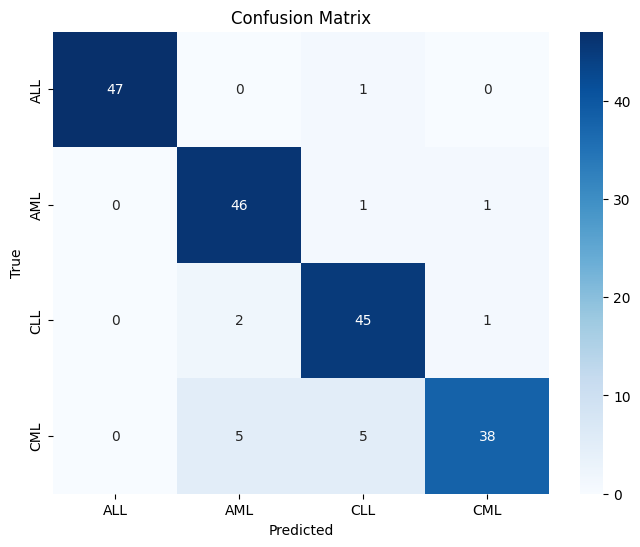

2025-09-13 08:41:49,781 - INFO - 
=== MULTI-TASK MODEL PIPELINE ===
2025-09-13 08:41:49,968 - INFO - --- Starting Multi-Task Model Training ---


Epoch 1/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:54,892 - INFO - Epoch 1/500 | Validation Type Acc: 0.5781
2025-09-13 08:41:54,988 - INFO - New best multi-task model saved with acc: 0.5781


Epoch 2/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:41:59,995 - INFO - Epoch 2/500 | Validation Type Acc: 0.5573


Epoch 3/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:05,103 - INFO - Epoch 3/500 | Validation Type Acc: 0.6667
2025-09-13 08:42:05,171 - INFO - New best multi-task model saved with acc: 0.6667


Epoch 4/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:09,952 - INFO - Epoch 4/500 | Validation Type Acc: 0.6719
2025-09-13 08:42:10,024 - INFO - New best multi-task model saved with acc: 0.6719


Epoch 5/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:14,992 - INFO - Epoch 5/500 | Validation Type Acc: 0.7188
2025-09-13 08:42:15,066 - INFO - New best multi-task model saved with acc: 0.7188


Epoch 6/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:19,985 - INFO - Epoch 6/500 | Validation Type Acc: 0.6562


Epoch 7/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:24,799 - INFO - Epoch 7/500 | Validation Type Acc: 0.6094


Epoch 8/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:29,814 - INFO - Epoch 8/500 | Validation Type Acc: 0.7396
2025-09-13 08:42:29,884 - INFO - New best multi-task model saved with acc: 0.7396


Epoch 9/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:35,127 - INFO - Epoch 9/500 | Validation Type Acc: 0.7344


Epoch 10/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:39,922 - INFO - Epoch 10/500 | Validation Type Acc: 0.7083


Epoch 11/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:45,097 - INFO - Epoch 11/500 | Validation Type Acc: 0.6927


Epoch 12/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:50,032 - INFO - Epoch 12/500 | Validation Type Acc: 0.7135


Epoch 13/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:54,868 - INFO - Epoch 13/500 | Validation Type Acc: 0.7083


Epoch 14/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:42:59,888 - INFO - Epoch 14/500 | Validation Type Acc: 0.7656
2025-09-13 08:42:59,959 - INFO - New best multi-task model saved with acc: 0.7656


Epoch 15/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:04,689 - INFO - Epoch 15/500 | Validation Type Acc: 0.7656


Epoch 16/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:09,591 - INFO - Epoch 16/500 | Validation Type Acc: 0.8073
2025-09-13 08:43:09,663 - INFO - New best multi-task model saved with acc: 0.8073


Epoch 17/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:14,748 - INFO - Epoch 17/500 | Validation Type Acc: 0.7135


Epoch 18/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:19,677 - INFO - Epoch 18/500 | Validation Type Acc: 0.7865


Epoch 19/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:24,755 - INFO - Epoch 19/500 | Validation Type Acc: 0.8177
2025-09-13 08:43:24,826 - INFO - New best multi-task model saved with acc: 0.8177


Epoch 20/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:29,838 - INFO - Epoch 20/500 | Validation Type Acc: 0.7656


Epoch 21/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:34,774 - INFO - Epoch 21/500 | Validation Type Acc: 0.7865


Epoch 22/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:39,885 - INFO - Epoch 22/500 | Validation Type Acc: 0.7865


Epoch 23/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:45,082 - INFO - Epoch 23/500 | Validation Type Acc: 0.7760


Epoch 24/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:50,071 - INFO - Epoch 24/500 | Validation Type Acc: 0.8229
2025-09-13 08:43:50,151 - INFO - New best multi-task model saved with acc: 0.8229


Epoch 25/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:43:55,211 - INFO - Epoch 25/500 | Validation Type Acc: 0.8281
2025-09-13 08:43:55,281 - INFO - New best multi-task model saved with acc: 0.8281


Epoch 26/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:00,168 - INFO - Epoch 26/500 | Validation Type Acc: 0.7812


Epoch 27/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:05,350 - INFO - Epoch 27/500 | Validation Type Acc: 0.7812


Epoch 28/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:10,268 - INFO - Epoch 28/500 | Validation Type Acc: 0.8125


Epoch 29/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:15,297 - INFO - Epoch 29/500 | Validation Type Acc: 0.8177


Epoch 30/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:20,630 - INFO - Epoch 30/500 | Validation Type Acc: 0.7344


Epoch 31/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:25,878 - INFO - Epoch 31/500 | Validation Type Acc: 0.8073


Epoch 32/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:31,516 - INFO - Epoch 32/500 | Validation Type Acc: 0.7656


Epoch 33/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:37,066 - INFO - Epoch 33/500 | Validation Type Acc: 0.8698
2025-09-13 08:44:37,220 - INFO - New best multi-task model saved with acc: 0.8698


Epoch 34/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:42,399 - INFO - Epoch 34/500 | Validation Type Acc: 0.7656


Epoch 35/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:47,922 - INFO - Epoch 35/500 | Validation Type Acc: 0.8438


Epoch 36/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:53,059 - INFO - Epoch 36/500 | Validation Type Acc: 0.8229


Epoch 37/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:44:58,183 - INFO - Epoch 37/500 | Validation Type Acc: 0.8854
2025-09-13 08:44:58,268 - INFO - New best multi-task model saved with acc: 0.8854


Epoch 38/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:03,296 - INFO - Epoch 38/500 | Validation Type Acc: 0.8125


Epoch 39/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:08,576 - INFO - Epoch 39/500 | Validation Type Acc: 0.8750


Epoch 40/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:13,828 - INFO - Epoch 40/500 | Validation Type Acc: 0.8438


Epoch 41/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:19,038 - INFO - Epoch 41/500 | Validation Type Acc: 0.8438


Epoch 42/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:24,246 - INFO - Epoch 42/500 | Validation Type Acc: 0.9010
2025-09-13 08:45:24,320 - INFO - New best multi-task model saved with acc: 0.9010


Epoch 43/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:29,277 - INFO - Epoch 43/500 | Validation Type Acc: 0.8490


Epoch 44/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:34,672 - INFO - Epoch 44/500 | Validation Type Acc: 0.8385


Epoch 45/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:39,921 - INFO - Epoch 45/500 | Validation Type Acc: 0.8125


Epoch 46/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:44,845 - INFO - Epoch 46/500 | Validation Type Acc: 0.8594


Epoch 47/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:50,435 - INFO - Epoch 47/500 | Validation Type Acc: 0.8698


Epoch 48/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:45:55,634 - INFO - Epoch 48/500 | Validation Type Acc: 0.8073


Epoch 49/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:00,699 - INFO - Epoch 49/500 | Validation Type Acc: 0.8333


Epoch 50/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:06,120 - INFO - Epoch 50/500 | Validation Type Acc: 0.8333


Epoch 51/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:11,114 - INFO - Epoch 51/500 | Validation Type Acc: 0.8542


Epoch 52/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:16,188 - INFO - Epoch 52/500 | Validation Type Acc: 0.8802


Epoch 53/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:21,124 - INFO - Epoch 53/500 | Validation Type Acc: 0.8177


Epoch 54/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:26,295 - INFO - Epoch 54/500 | Validation Type Acc: 0.8438


Epoch 55/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:31,441 - INFO - Epoch 55/500 | Validation Type Acc: 0.7500


Epoch 56/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:36,578 - INFO - Epoch 56/500 | Validation Type Acc: 0.8438


Epoch 57/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:41,925 - INFO - Epoch 57/500 | Validation Type Acc: 0.8073


Epoch 58/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:47,119 - INFO - Epoch 58/500 | Validation Type Acc: 0.7240


Epoch 59/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:52,231 - INFO - Epoch 59/500 | Validation Type Acc: 0.8385


Epoch 60/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:46:57,218 - INFO - Epoch 60/500 | Validation Type Acc: 0.8594


Epoch 61/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:02,194 - INFO - Epoch 61/500 | Validation Type Acc: 0.8385


Epoch 62/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:07,793 - INFO - Epoch 62/500 | Validation Type Acc: 0.8594


Epoch 63/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:13,294 - INFO - Epoch 63/500 | Validation Type Acc: 0.8594


Epoch 64/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:18,765 - INFO - Epoch 64/500 | Validation Type Acc: 0.8333


Epoch 65/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:24,093 - INFO - Epoch 65/500 | Validation Type Acc: 0.8750


Epoch 66/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:29,184 - INFO - Epoch 66/500 | Validation Type Acc: 0.8177


Epoch 67/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:34,307 - INFO - Epoch 67/500 | Validation Type Acc: 0.8646


Epoch 68/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:39,669 - INFO - Epoch 68/500 | Validation Type Acc: 0.9062
2025-09-13 08:47:39,742 - INFO - New best multi-task model saved with acc: 0.9062


Epoch 69/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:44,805 - INFO - Epoch 69/500 | Validation Type Acc: 0.8802


Epoch 70/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:49,950 - INFO - Epoch 70/500 | Validation Type Acc: 0.8698


Epoch 71/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:47:55,183 - INFO - Epoch 71/500 | Validation Type Acc: 0.9323
2025-09-13 08:47:55,251 - INFO - New best multi-task model saved with acc: 0.9323


Epoch 72/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:00,255 - INFO - Epoch 72/500 | Validation Type Acc: 0.8542


Epoch 73/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:05,453 - INFO - Epoch 73/500 | Validation Type Acc: 0.8646


Epoch 74/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:10,536 - INFO - Epoch 74/500 | Validation Type Acc: 0.8958


Epoch 75/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:15,628 - INFO - Epoch 75/500 | Validation Type Acc: 0.9271


Epoch 76/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:20,766 - INFO - Epoch 76/500 | Validation Type Acc: 0.9115


Epoch 77/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:25,927 - INFO - Epoch 77/500 | Validation Type Acc: 0.9010


Epoch 78/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:30,969 - INFO - Epoch 78/500 | Validation Type Acc: 0.8802


Epoch 79/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:36,380 - INFO - Epoch 79/500 | Validation Type Acc: 0.8229


Epoch 80/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:41,658 - INFO - Epoch 80/500 | Validation Type Acc: 0.9010


Epoch 81/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:46,717 - INFO - Epoch 81/500 | Validation Type Acc: 0.8906


Epoch 82/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:51,734 - INFO - Epoch 82/500 | Validation Type Acc: 0.8177


Epoch 83/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:48:57,091 - INFO - Epoch 83/500 | Validation Type Acc: 0.8542


Epoch 84/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:02,178 - INFO - Epoch 84/500 | Validation Type Acc: 0.9115


Epoch 85/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:07,411 - INFO - Epoch 85/500 | Validation Type Acc: 0.9010


Epoch 86/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:12,326 - INFO - Epoch 86/500 | Validation Type Acc: 0.8958


Epoch 87/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:17,345 - INFO - Epoch 87/500 | Validation Type Acc: 0.8490


Epoch 88/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:22,492 - INFO - Epoch 88/500 | Validation Type Acc: 0.8854


Epoch 89/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:27,539 - INFO - Epoch 89/500 | Validation Type Acc: 0.8802


Epoch 90/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:32,681 - INFO - Epoch 90/500 | Validation Type Acc: 0.8906


Epoch 91/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:37,686 - INFO - Epoch 91/500 | Validation Type Acc: 0.8385


Epoch 92/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:42,716 - INFO - Epoch 92/500 | Validation Type Acc: 0.8854


Epoch 93/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:47,937 - INFO - Epoch 93/500 | Validation Type Acc: 0.8802


Epoch 94/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:53,472 - INFO - Epoch 94/500 | Validation Type Acc: 0.8385


Epoch 95/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:49:58,528 - INFO - Epoch 95/500 | Validation Type Acc: 0.8906


Epoch 96/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:03,731 - INFO - Epoch 96/500 | Validation Type Acc: 0.8281


Epoch 97/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:09,150 - INFO - Epoch 97/500 | Validation Type Acc: 0.8646


Epoch 98/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:14,259 - INFO - Epoch 98/500 | Validation Type Acc: 0.8646


Epoch 99/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:19,295 - INFO - Epoch 99/500 | Validation Type Acc: 0.8594


Epoch 100/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:24,342 - INFO - Epoch 100/500 | Validation Type Acc: 0.8698


Epoch 101/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:29,365 - INFO - Epoch 101/500 | Validation Type Acc: 0.8958


Epoch 102/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:34,618 - INFO - Epoch 102/500 | Validation Type Acc: 0.8802


Epoch 103/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:39,516 - INFO - Epoch 103/500 | Validation Type Acc: 0.8854


Epoch 104/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:44,376 - INFO - Epoch 104/500 | Validation Type Acc: 0.9115


Epoch 105/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:49,566 - INFO - Epoch 105/500 | Validation Type Acc: 0.8854


Epoch 106/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:54,546 - INFO - Epoch 106/500 | Validation Type Acc: 0.9062


Epoch 107/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:50:59,544 - INFO - Epoch 107/500 | Validation Type Acc: 0.8750


Epoch 108/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:04,603 - INFO - Epoch 108/500 | Validation Type Acc: 0.7917


Epoch 109/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:09,532 - INFO - Epoch 109/500 | Validation Type Acc: 0.8958


Epoch 110/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:14,595 - INFO - Epoch 110/500 | Validation Type Acc: 0.8542


Epoch 111/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:19,524 - INFO - Epoch 111/500 | Validation Type Acc: 0.8750


Epoch 112/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:24,310 - INFO - Epoch 112/500 | Validation Type Acc: 0.8958


Epoch 113/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:29,324 - INFO - Epoch 113/500 | Validation Type Acc: 0.8333


Epoch 114/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:34,232 - INFO - Epoch 114/500 | Validation Type Acc: 0.8646


Epoch 115/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:39,055 - INFO - Epoch 115/500 | Validation Type Acc: 0.8958


Epoch 116/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:43,979 - INFO - Epoch 116/500 | Validation Type Acc: 0.9115


Epoch 117/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:48,784 - INFO - Epoch 117/500 | Validation Type Acc: 0.9167


Epoch 118/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:53,628 - INFO - Epoch 118/500 | Validation Type Acc: 0.7969


Epoch 119/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:51:58,580 - INFO - Epoch 119/500 | Validation Type Acc: 0.8542


Epoch 120/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:03,437 - INFO - Epoch 120/500 | Validation Type Acc: 0.9062


Epoch 121/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:08,335 - INFO - Epoch 121/500 | Validation Type Acc: 0.8698


Epoch 122/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:13,202 - INFO - Epoch 122/500 | Validation Type Acc: 0.8906


Epoch 123/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:18,051 - INFO - Epoch 123/500 | Validation Type Acc: 0.8646


Epoch 124/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:22,924 - INFO - Epoch 124/500 | Validation Type Acc: 0.8542


Epoch 125/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:27,692 - INFO - Epoch 125/500 | Validation Type Acc: 0.8229


Epoch 126/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:32,583 - INFO - Epoch 126/500 | Validation Type Acc: 0.8698


Epoch 127/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:37,355 - INFO - Epoch 127/500 | Validation Type Acc: 0.8854


Epoch 128/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:42,045 - INFO - Epoch 128/500 | Validation Type Acc: 0.8906


Epoch 129/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:46,849 - INFO - Epoch 129/500 | Validation Type Acc: 0.9062


Epoch 130/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:51,659 - INFO - Epoch 130/500 | Validation Type Acc: 0.9062


Epoch 131/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:52:56,590 - INFO - Epoch 131/500 | Validation Type Acc: 0.8646


Epoch 132/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:01,466 - INFO - Epoch 132/500 | Validation Type Acc: 0.8854


Epoch 133/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:06,427 - INFO - Epoch 133/500 | Validation Type Acc: 0.8542


Epoch 134/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:11,352 - INFO - Epoch 134/500 | Validation Type Acc: 0.7604


Epoch 135/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:16,503 - INFO - Epoch 135/500 | Validation Type Acc: 0.7760


Epoch 136/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:21,400 - INFO - Epoch 136/500 | Validation Type Acc: 0.8646


Epoch 137/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:26,346 - INFO - Epoch 137/500 | Validation Type Acc: 0.9062


Epoch 138/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:31,169 - INFO - Epoch 138/500 | Validation Type Acc: 0.8750


Epoch 139/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:36,187 - INFO - Epoch 139/500 | Validation Type Acc: 0.8698


Epoch 140/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:41,005 - INFO - Epoch 140/500 | Validation Type Acc: 0.8542


Epoch 141/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:45,833 - INFO - Epoch 141/500 | Validation Type Acc: 0.8958


Epoch 142/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:50,578 - INFO - Epoch 142/500 | Validation Type Acc: 0.8854


Epoch 143/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:53:55,411 - INFO - Epoch 143/500 | Validation Type Acc: 0.9167


Epoch 144/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:00,201 - INFO - Epoch 144/500 | Validation Type Acc: 0.8906


Epoch 145/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:05,008 - INFO - Epoch 145/500 | Validation Type Acc: 0.8906


Epoch 146/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:09,816 - INFO - Epoch 146/500 | Validation Type Acc: 0.9010


Epoch 147/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:14,732 - INFO - Epoch 147/500 | Validation Type Acc: 0.8333


Epoch 148/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:19,511 - INFO - Epoch 148/500 | Validation Type Acc: 0.8542


Epoch 149/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:24,330 - INFO - Epoch 149/500 | Validation Type Acc: 0.8750


Epoch 150/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:29,050 - INFO - Epoch 150/500 | Validation Type Acc: 0.8594


Epoch 151/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:33,850 - INFO - Epoch 151/500 | Validation Type Acc: 0.9010


Epoch 152/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:38,670 - INFO - Epoch 152/500 | Validation Type Acc: 0.8802


Epoch 153/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:43,585 - INFO - Epoch 153/500 | Validation Type Acc: 0.8854


Epoch 154/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:48,399 - INFO - Epoch 154/500 | Validation Type Acc: 0.9010


Epoch 155/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:53,172 - INFO - Epoch 155/500 | Validation Type Acc: 0.8646


Epoch 156/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:54:58,105 - INFO - Epoch 156/500 | Validation Type Acc: 0.8542


Epoch 157/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:02,929 - INFO - Epoch 157/500 | Validation Type Acc: 0.9010


Epoch 158/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:07,817 - INFO - Epoch 158/500 | Validation Type Acc: 0.8958


Epoch 159/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:12,641 - INFO - Epoch 159/500 | Validation Type Acc: 0.8490


Epoch 160/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:17,432 - INFO - Epoch 160/500 | Validation Type Acc: 0.8750


Epoch 161/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:22,256 - INFO - Epoch 161/500 | Validation Type Acc: 0.8646


Epoch 162/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:27,013 - INFO - Epoch 162/500 | Validation Type Acc: 0.8646


Epoch 163/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:31,822 - INFO - Epoch 163/500 | Validation Type Acc: 0.8490


Epoch 164/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:36,666 - INFO - Epoch 164/500 | Validation Type Acc: 0.8802


Epoch 165/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:41,490 - INFO - Epoch 165/500 | Validation Type Acc: 0.8750


Epoch 166/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:46,363 - INFO - Epoch 166/500 | Validation Type Acc: 0.8854


Epoch 167/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:51,251 - INFO - Epoch 167/500 | Validation Type Acc: 0.8958


Epoch 168/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:55:56,084 - INFO - Epoch 168/500 | Validation Type Acc: 0.8385


Epoch 169/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:00,905 - INFO - Epoch 169/500 | Validation Type Acc: 0.9010


Epoch 170/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:05,876 - INFO - Epoch 170/500 | Validation Type Acc: 0.9062


Epoch 171/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:10,733 - INFO - Epoch 171/500 | Validation Type Acc: 0.8750


Epoch 172/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:15,569 - INFO - Epoch 172/500 | Validation Type Acc: 0.8646


Epoch 173/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:20,469 - INFO - Epoch 173/500 | Validation Type Acc: 0.8698


Epoch 174/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:25,453 - INFO - Epoch 174/500 | Validation Type Acc: 0.8177


Epoch 175/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:30,601 - INFO - Epoch 175/500 | Validation Type Acc: 0.8281


Epoch 176/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:35,566 - INFO - Epoch 176/500 | Validation Type Acc: 0.8333


Epoch 177/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:40,487 - INFO - Epoch 177/500 | Validation Type Acc: 0.7969


Epoch 178/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:45,393 - INFO - Epoch 178/500 | Validation Type Acc: 0.8594


Epoch 179/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:50,247 - INFO - Epoch 179/500 | Validation Type Acc: 0.8802


Epoch 180/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:56:55,208 - INFO - Epoch 180/500 | Validation Type Acc: 0.8542


Epoch 181/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:00,541 - INFO - Epoch 181/500 | Validation Type Acc: 0.8698


Epoch 182/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:05,909 - INFO - Epoch 182/500 | Validation Type Acc: 0.8906


Epoch 183/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:10,780 - INFO - Epoch 183/500 | Validation Type Acc: 0.8958


Epoch 184/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:15,692 - INFO - Epoch 184/500 | Validation Type Acc: 0.8542


Epoch 185/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:20,621 - INFO - Epoch 185/500 | Validation Type Acc: 0.8958


Epoch 186/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:25,540 - INFO - Epoch 186/500 | Validation Type Acc: 0.9062


Epoch 187/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:30,512 - INFO - Epoch 187/500 | Validation Type Acc: 0.9219


Epoch 188/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:35,504 - INFO - Epoch 188/500 | Validation Type Acc: 0.9219


Epoch 189/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:40,584 - INFO - Epoch 189/500 | Validation Type Acc: 0.9010


Epoch 190/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:45,402 - INFO - Epoch 190/500 | Validation Type Acc: 0.9115


Epoch 191/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:50,213 - INFO - Epoch 191/500 | Validation Type Acc: 0.9219


Epoch 192/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:54,885 - INFO - Epoch 192/500 | Validation Type Acc: 0.9167


Epoch 193/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:57:59,518 - INFO - Epoch 193/500 | Validation Type Acc: 0.9010


Epoch 194/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:58:04,133 - INFO - Epoch 194/500 | Validation Type Acc: 0.9062


Epoch 195/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:58:08,796 - INFO - Epoch 195/500 | Validation Type Acc: 0.9115


Epoch 196/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:58:13,755 - INFO - Epoch 196/500 | Validation Type Acc: 0.9167


Epoch 197/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

2025-09-13 08:58:19,199 - INFO - Epoch 197/500 | Validation Type Acc: 0.9062


Epoch 198/500 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
setup_logging()

MODEL_DIR.mkdir(parents=True, exist_ok=True)

if not SKIP_DATA_PREP:
    data_prep_success = prepare_data()
    if not data_prep_success:
        raise RuntimeError("Data preparation failed. Check logs for details.")
else:
    logging.info("Skipping data preparation as requested.")

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
logging.info(f"Using device: {device}")

tfm_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
tfm_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

logging.info("\n=== BASELINE MODEL PIPELINE ===")
train_ds = datasets.ImageFolder(str(TRAIN_DIR), tfm_train)
val_ds = datasets.ImageFolder(str(VAL_DIR), tfm_eval)
test_ds = datasets.ImageFolder(str(TEST_DIR), tfm_eval)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

baseline_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, len(CLASSES))

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseline_model.parameters(), lr=LEARNING_RATE)

train_baseline_model(baseline_model, criterion, optimizer, train_dl, val_dl, device, NUM_EPOCHS)

logging.info("\nLoading best baseline model for final evaluation.")
baseline_model.load_state_dict(torch.load(MODEL_DIR / 'baseline_cls.pt'))
evaluate_model(baseline_model, test_dl, device, class_names=CLASSES)

logging.info("\n=== MULTI-TASK MODEL PIPELINE ===")
mt_train_ds = MultiTaskDataset(str(TRAIN_DIR), tfm_train)
mt_val_ds = MultiTaskDataset(str(VAL_DIR), tfm_eval)

mt_train_dl = DataLoader(mt_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
mt_val_dl = DataLoader(mt_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

multitask_model = MultiTaskModel(n_types=len(CLASSES), n_grades=len(GRADES))

mt_criteria = (nn.CrossEntropyLoss(), nn.CrossEntropyLoss())
mt_optimizer = optim.AdamW(multitask_model.parameters(), lr=LEARNING_RATE)

train_multitask_model(multitask_model, mt_criteria, mt_optimizer, mt_train_dl, mt_val_dl, device, NUM_EPOCHS)

logging.info("\nPipeline finished successfully.")

## 4. Making a Prediction on a New Image

After training, you can use this section to load your best `multitask_model` and make a prediction on any single image file.

In [11]:
def predict_leukemia(model_path, image_path, device):
    """
    Loads the trained multi-task model and predicts the class and grade
    for a single input image.
    """
    # 1. Initialize the model architecture (the class MultiTaskModel must be defined)
    model = MultiTaskModel(n_types=len(CLASSES), n_grades=len(GRADES))
    
    # 2. Load the saved weights
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.to(device)
    
    # 3. Set the model to evaluation mode
    model.eval()

    # 4. Define the same image transformations as used for validation/testing
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 5. Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    # 6. Make a prediction
    with torch.no_grad():
        type_logits, grade_logits = model(image_tensor)
        type_pred_idx = torch.argmax(type_logits, dim=1).item()
        grade_pred_idx = torch.argmax(grade_logits, dim=1).item()

    # 7. Map the index back to the class and grade names
    predicted_class = CLASSES[type_pred_idx]
    predicted_grade = GRADES[grade_pred_idx]
    
    return (predicted_class, predicted_grade)

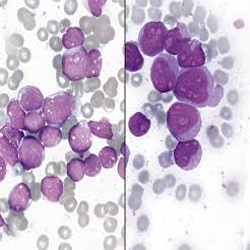

🚀 Prediction Complete!
   - Predicted Class: AML
   - Predicted Grade: Accelerated


In [ ]:
# --- SETTINGS FOR PREDICTION ---
SAVED_MODEL_PATH = MODEL_DIR / 'multitask_model.pt'

# ✅ IMPORTANT: Change this to the path of the image you want to classify!
YOUR_IMAGE_PATH = input('Enter the path of image:')#'/Users/adarshainamdar/Documents/Major_Project/Unknown-2.jpeg' 

# --- RUN PREDICTION ---
try:
    # Display the image
    display(Image.open(YOUR_IMAGE_PATH).resize((250, 250)))
    
    predicted_class, predicted_grade = predict_leukemia(
        model_path=SAVED_MODEL_PATH,
        image_path=YOUR_IMAGE_PATH,
        device=device # This 'device' variable was defined in the training cell
    )

    print("🚀 Prediction Complete!")
    print(f"   - Predicted Class: {predicted_class}")
    print(f"   - Predicted Grade: {predicted_grade}")

except FileNotFoundError:
    # print(f"Error: The image file was not found at '{YOUR_IMAGE_PATH}'")
    print("Please make sure the path is correct and re-run the cell.")
except Exception as e:
    print(f"An error occurred: {e}")